The last time I studied neural networks in detail was five years ago in college. I did touch upon backpropagation when Andrew Ng's machine learning MOOC was offered on Coursera for the first time, but beyond that I've only dabbled with them through [keras](http://keras.io). Then recently, when I read about Coursera's imminent decision to pull down much of their freely available material (you can read a rant about it [here](http://reachtarunhere.github.io/2016/06/11/Golden-Age-of-MOOCs-is-over-and-why-I-hate-Coursera/)), I went on a downloading spree (many thanks to the wonderful [coursera-dl](http://github.com/coursera-dl/coursera-dl)). Of all the courses I downloaded, the one that caught my eye was Geoffrey Hinton's course on _Neural Networks for Machine Learning_. Because of that and the fact that there were some computer vision projects going on at work, I decided to dive right in.

Hinton's course is wonderful. He is funny, and unsurprisingly, very very insightful about the core concepts in neural networks. One of the signs of this is the fact that this course is not at all cluttered with too much mathematics, and can be traveresed by someone with only a working knowledge of calculus. One of his most insightful moments in the course is when he describes the Perceptron learning rule as simply as follows:

* If the perceptron makes no mistake, leave it alone.
* If it predicts a false negative, add the input vector to the weight vector
* If it predicts a false positive, subtract the input vector from the weight vector

This is so simple, that a literal implementation of this can make train a perceptron reasonably well (as we shall see). There are of course, numerous heuristics required when applying it in production, but the training algorithm is just this simple. Now, the popularity of the perceptron is because it guarantees linear convergence, i.e. if a binary classification problem is linearly separable in the feature space, the perceptron will _always eventually_ learn to correctly classify the input samples. An algebraic or analytical proof of this can be found anywhere, but relies almost always on the [Cauchy-Schwarz inequality](https://en.wikipedia.org/wiki/Cauchy%E2%80%93Schwarz_inequality). I thought that since the learning rule is so simple, then there must be a way to understand the convergence theorem using nothing more than the learning rule itself, and some simple data visualization. I think I've found a reasonable explanation, which is what this post is broadly about. But first, let's see a simple demonstration of training a perceptron.

## A Demo Perceptron

Let's make some sample data which is linearly separable. Let's also initialize the weights for a perceptron. For simplicity, we shall do away with the bias, and make sure that the data is centered at the origin

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = make_blobs(centers=[[1, 1], [-1, -1]], cluster_std=0.5)
np.random.seed(3)
weights = np.array([[-1], [1]], dtype=float)

Let's also define a function that makes a scatterplot of the data and draws the decision boundary through it, based on the weights. The decision function we use is as follows

$$z = \sum_{i=1}^{N}w_{i}x_{i}$$

Where $N$ is the dimensionality, $x_{i}$ is the $i$th dimension of the input sample, and $w_{i}$ is the corresponding weight.

The prediction $y$ is 1 if $z \geq 0$ and 0 otherwise. Thus, the decision line in the feature space (consisting in this case of $x_{1}$ and $x_{2}$) is defined as follows:

$$ w_{1}x_{1} + w_{2}x_{2} = 0 $$

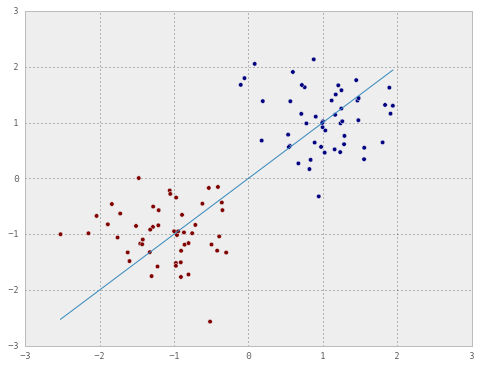

In [3]:
def plot_decision(X, y, weights):
    """Show the scatterplot of the data colored by the classes,
    draw the decision line based on the weights."""
    xx = np.linspace(X[:, 0].min(), X[:, 0].max())
    yy = - weights[0] * xx / weights[1]
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.plot(xx, yy)

plot_decision(X, y, weights)

Note that I've specifically chosen the weights such that the decision boundary ends up in the worst possible position. Now let's train the perceptron in batch mode on one epoch of the training set.

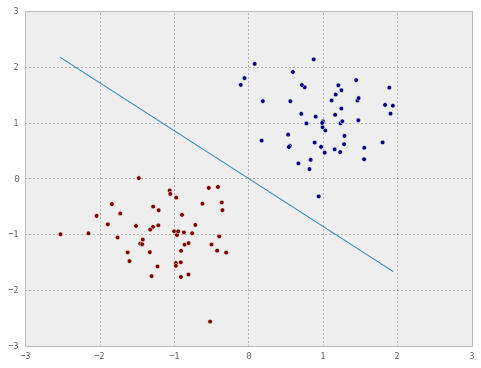

In [4]:
prediction = np.dot(X, weights).ravel().astype(int)
# indentify the misclassifications
false_pos = np.logical_and(y == 0, prediction == 1)
false_neg = np.logical_and(y == 1, prediction == 0)
# add the false negatives
weights += X[false_neg, :].sum(0).reshape(-1, 1)
# subtract the false positives
weights -= X[false_pos, :].sum(0).reshape(-1, 1)

# plot the data again
plot_decision(X, y, weights)

It can be seen that one epoch or a hundred iterations (maybe less) are enough to train the perceptron. Now let's do the same in online mode. This time, we will store the weights updated at each iteration so we can have a look at them later.

In [5]:
# reset the weights
weights = np.array([[-1], [1]], dtype=float)
updated_weights = np.zeros((100, 2))
for i in range(X.shape[0]):
    updated_weights[i, :] = weights.ravel()  # store the weights
    training_sample = X[i, :]
    target = y[i]
    prediction = np.dot(training_sample, weights).ravel().astype(int)
    if target != prediction:
        if target == 0 and prediction == 1:  # false positive
            weights -= training_sample.reshape(-1, 1)
        elif target == 1 and prediction == 0:  # false negative
            weights += training_sample.reshape(-1, 1)

The two snippets above achieve exactly the same effect, except that the first is faster since it is vectorized. Now that we have the weight updates for every training sample, let's plot the decision boundary for a few of them.

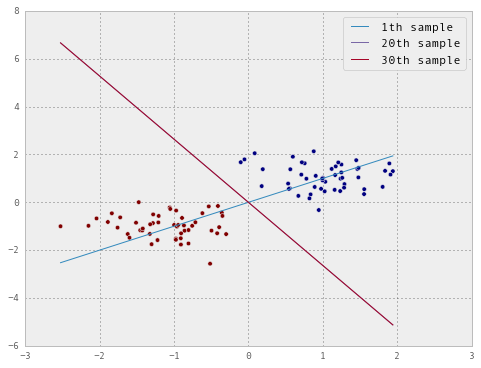

In [6]:
sample_ix = [1, 20, 30]
xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y)

for ix in sample_ix:
    wghts = updated_weights[ix, :]
    yy = - wghts[0] * xx / wghts[1]
    plt.plot(xx, yy, label="{}th sample".format(ix))
plt.legend()

As we move from thethe first to the twentieth and then to the thirtieth sample, we can see that the decision boundary is rotating counter clockwise. By the thirtieth sample, it has found that gap that separates the two blobs, so it stops making mistakes, and therefore stops learning. Now let's try and see why this will _always_ happen, as long as there is such a gap to be found, irrespective of the topology of the data or the number of points in the dataset.

## The Proof

We shall continue, for the sake of simplicity, our assumption of the data being centered at the origin and therefore not needing a bias term in the learning. For better visualization, we will also impose a restriction on the weight vector - that it needs to have a unit norm. Note that the magnitude of the weight vector does not matter, since it is only its gradient that actually affects the predictions, and therefore we can comfortably impose this restriction. Moreover, I'm insisting on this restriction only to make the plots look pretty.

Consider the following dataset:

In [7]:
X = np.array([[-0.5, 1],
              [-1, -0.2],
              [0.5, -1],
              [1, -0.2]])
y = np.array([1, 1, 0, 0])
weights = np.array([0.707, 0.707])

Now, we arrange the training samples and the weights in a cartesian plane, by their position vectors.

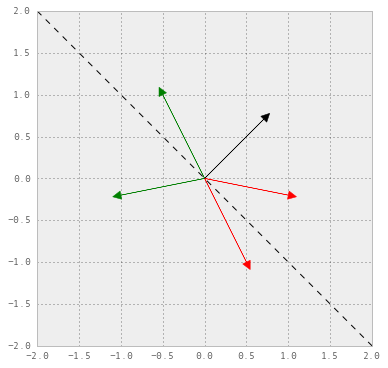

In [8]:
cls_color = ["r", "g"]
plt.figure(figsize=(6, 6))
ax = plt.axes()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
for i in range(4):
    ax.arrow(0, 0, X[i, 0], X[i, 1], fc=cls_color[y[i]], ec=cls_color[y[i]], head_length=0.1,
             head_width=0.1)
ax.arrow(0, 0, weights[0], weights[1], fc="k", ec="k", head_width=0.1, head_length=0.1)

# decision boundary:
xx = np.linspace(-2, 2, 100)
yy = -weights[0] * xx / weights[1]
ax.plot(xx, yy, "k--")

The green arrows denote the true positives, the red one denote the true negatives, the black arrow is the weight vector and the black dashed line denotes the decision boundary. Our hypothesis based on this decision boundary is equivalent to saying that any point in the upper right triangle would be assigned a positive prediction, and any point in the lower left triangle would be assigned a negative prediction. In the given dataset, this hypothesis clearly makes two mistakes - one false positive and one false negative.

Analogous to the previous example, we know that the perceptron will converge if the weight vector (and hence the decision boundary) keeps rotating. Let's assume that it rotates counter-clockwise. Proving the convergence, then, can be reduced into proving the following parts:

* **Part A**: No sample will ever make the weight vector rotate clockwise.
* **Part B**: The weight vector will not rotate enough to make the decision boundary jump _across_ the gap between the two classes.

Let us apply the learning rule to this perceptron, and see how we can prove both Part A and Part B. Since there is one false positive and one false negative, the training simply consists of adding the false negative to the weight vector and subtracting the false positive from it.

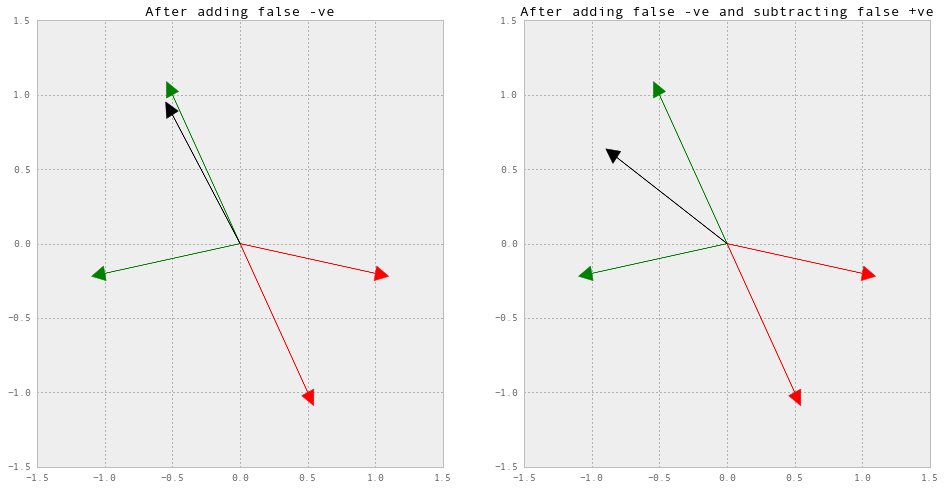

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax1.axis([-1.5, 1.5, -1.5, 1.5])
ax2.axis([-1.5, 1.5, -1.5, 1.5])
# original weights
weights = np.array([0.707, 0.707])

# adding the false negative and normalizing
weights += [-1, -0.2]
weights = weights / np.linalg.norm(weights)
for i in range(4):
    ax1.arrow(0, 0, X[i, 0], X[i, 1], fc=cls_color[y[i]], ec=cls_color[y[i]], head_length=0.1,
             head_width=0.1)
ax1.arrow(0, 0, weights[0], weights[1], fc="k", ec="k", head_width=0.1, head_length=0.1)
ax1.set_title("After adding false -ve")

# subtracting the false positive and normalizing
weights -= [1, -0.2]
weights = weights / np.linalg.norm(weights)
for i in range(4):
    ax2.arrow(0, 0, X[i, 0], X[i, 1], fc=cls_color[y[i]], ec=cls_color[y[i]], head_length=0.1,
             head_width=0.1)
ax2.arrow(0, 0, weights[0], weights[1], fc="k", ec="k", head_width=0.1, head_length=0.1)
ax2.set_title("After adding false -ve and subtracting false +ve")

## Part A
Suppose a false negative makes and angle $\theta_{n}$ with the weight vector. Since the decision boundary is orothogonal to the weight vector, no matter which iteration of learning the perceptron is, every possible $\theta_{n}$ will be such that $\frac{\pi}{2} \leq \theta_{n} \leq \frac{3\pi}{2}$. In order to make the weight vector rotate clockwise, a vector which makes an angle of $\leq \frac{\pi}{2}$ must be added to it. But because of the orthogonality between the weight vector and the decision boundary, no false negative can have this property! Thus, there will never exist a false negative that makes the weight vector rotate clockwise.

In the same way, suppose a false positive makes an angle $\theta_{p}$ with the weight vector. Again, every possible $\theta_{p}$ will be such that $-\frac{\pi}{2} \leq \theta_{p} \leq \frac{\pi}{2}$. Here, too, there can't exist a vector which when subtracted from the weight vector will make it rotate clockwise. Thus, there will never exist a false positive that makes the weight vector rotate clockwise.

In the context of the example, the only way that the weight vector could rotate clockwise was if there was a green vector sticking between the two red vectors, or vice versa. In both these cases, linear separability would not be possible (remember that we are assuming no bias), and hence the convergence would fail by definition.

## Part B
Recall that in order to make corrections, what we are adding to (or subtracting from) the weights are the sample vectors themselves - not some linear function of them. In other words, whenever the perceptron learns, it learns not only to be right, but to be right by a very specific margin. This margin is nothing but the magnitude of the last mistake it made! Now, the only way that this margin can be large enough to push the decision boundary overboard, is, say, if a false positive is positioned to be in the half-plane of the negative classes. In this case too, linear separability cannot be verified, and again the convergence fails by defintion.

-------------


I understand that this isn't really a "proof" proof. It is an explanation at best. False advertising. If you can find a simpler, or a more intuitive explanation, please leave a link in the comments.